In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import circuitsvis as cv

import matplotlib.pyplot as plt
import numpy as np
import re
from collections import OrderedDict
import os
import random
import json

from transformers import GPT2LMHeadModel, AutoConfig, PreTrainedTokenizerBase
from transformer_lens import HookedTransformer, HookedTransformerConfig
import importlib
from train import*

torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False)


### TransformerLens Implementation

In [5]:
probed_model_path = "../training_outputs/addition_fixed/checkpoint-59350"

probed_model = GPT2LMHeadModel.from_pretrained(probed_model_path)
tokenizer = customTokenizer()

hooked_model = HookedTransformer.from_pretrained(
        "gpt2",
        hf_model=probed_model,
        tokenizer=None,
        n_embd=probed_model.config.n_embd,
        n_layer=probed_model.config.n_layer,
        n_head=probed_model.config.n_head,
        vocab_size=probed_model.config.vocab_size,
        n_positions=probed_model.config.n_positions,
        n_ctx=probed_model.config.n_positions,
)


hooked_model.eval()
del probed_model
hooked_model.tokenizer = tokenizer



Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer


In [9]:
train_dataset, test_dataset = make_dataset(tokenizer)
x = train_dataset[random.randint(0, len(train_dataset)-1)]
# x = train_dataset._number_to_ids(101, 539)
# x = train_dataset._number_to_ids(615, 861)
x = train_dataset._number_to_ids(403, 288)

pred, cache = hooked_model.run_with_cache(torch.LongTensor([x]), return_type="logits")

s = x.index(tokenizer.vocab["="])
e = x.index(tokenizer.eos_token_id) - 1
pred = pred.squeeze(0)[s:e].argmax(dim=1).tolist()

print("input", "".join(tokenizer.convert_ids_to_tokens(x)))
print("pred", pred)



input B304+882=196EP
pred [1, 9, 6]


In [12]:
layer_idx = 1
attention_pattern = cache[f"blocks.{layer_idx}.attn.hook_pattern"][0]

weighted_by_v_norm = False
if weighted_by_v_norm:
    v_vector = cache[f"blocks.{layer_idx}.attn.hook_v"][0]
    v_norm = torch.linalg.vector_norm(v_vector, dim=-1)
    attention_pattern = attention_pattern * v_norm.transpose(0, 1).unsqueeze(1)
    attention_pattern /= 3
str_tokens = ["&nbsp;"+i+"&nbsp;" for i in tokenizer.convert_ids_to_tokens(x)]
cv.attention.attention_patterns(tokens=str_tokens, attention=attention_pattern)

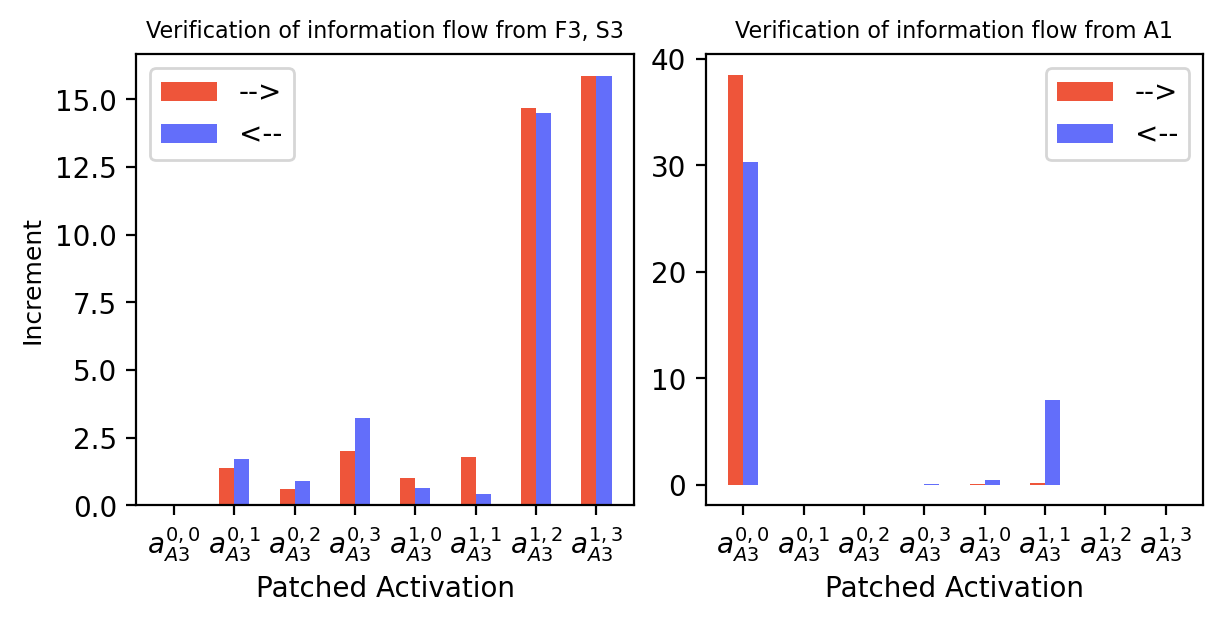

In [14]:
# with open("causal_exp.json") as f:
#     results = json.load(f)

fig, ax = plt.subplots(1, 2, figsize=(6,3), layout='constrained')
fig.set_dpi(200)
width = 0.25

results = {'forward': {'heads': [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3)], 'values': [-1.9991199131652593e-05, 1.3810264809505632, 1.9968409445830027, 4.003503319442009, 5.034646968101104, 6.808616071224236, 21.478738773190305, 37.350440168504775]}, 'backward': {'heads': [(1, 3), (1, 2), (1, 1), (1, 0), (0, 3), (0, 2), (0, 1), (0, 0)], 'values': [15.866359063253544, 30.38138489593167, 30.82171984212036, 31.481932447724503, 34.71425512880084, 35.608731115521756, 37.31407471395208, 37.35823991688051]}}

heads = results["forward"]["heads"]

forward_values = results["forward"]["values"]
backward_values = results["backward"]["values"]
forward_values.insert(0, 0)
backward_values.insert(0, 0)
forward_values = np.array(forward_values)
forward_values = forward_values[1:] - forward_values[:-1]
backward_values = np.array(backward_values)
backward_values = backward_values[1:] - backward_values[:-1]
backward_values = np.flip(backward_values)


x = np.arange(len(heads))
rects = ax[0].bar(x-width/2, forward_values, width, label="-->", color="#EE553A")
rects = ax[0].bar(x+width/2, backward_values, width, label="<--", color="#636EFA")

ax[0].set_ylabel(r"Increment", fontsize=9)  #  of $(LD_{orig}-LD_{pch})$
ax[0].set_xlabel("Patched Activation")
ax[0].set_title("Verification of information flow from F3, S3", fontsize=8)
ax[0].legend(ncols=1) #loc="upper right", 
# ax.set_ylim(0, 15)

head_labels = ["$a^{%d,%d}_{A3}$"%(l, h) for l, h in heads]
ax[0].set_xticks(x, head_labels)


results = {'forward': {'heads': [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3)], 'values': [38.51468480801053, 38.50872252170892, 38.50375321903935, 38.52791429918077, 38.626071560857326, 38.77775327834141, 38.784715952291606, 38.79566357152491]}, 'backward': {'heads': [(1, 3), (1, 2), (1, 1), (1, 0), (0, 3), (0, 2), (0, 1), (0, 0)], 'values': [-0.007767616592218474, -0.027007276332525976, 7.962263913415978, 8.441564627659172, 8.47005752056734, 8.45936695115831, 8.473442410108778, 38.802275314971546]}}


heads = results["forward"]["heads"]

forward_values = results["forward"]["values"]
backward_values = results["backward"]["values"]
forward_values.insert(0, 0)
backward_values.insert(0, 0)
forward_values = np.array(forward_values)
forward_values = forward_values[1:] - forward_values[:-1]
backward_values = np.array(backward_values)
backward_values = backward_values[1:] - backward_values[:-1]
backward_values = np.flip(backward_values)


x = np.arange(len(heads))
rects = ax[1].bar(x-width/2, forward_values, width, label="-->", color="#EE553A")#color=(254/255, 129/255, 125/255))
rects = ax[1].bar(x+width/2, backward_values, width, label="<--", color="#636EFA") #color=(129/255, 184/255, 223/255))

# ax[1].set_ylabel(r"Increment of $\Delta LD$")
ax[1].set_xlabel("Patched Activation")
ax[1].set_title("Verification of information flow from A1", fontsize=8)
ax[1].legend(ncols=1)
# ax.set_ylim(0, 15)

head_labels = ["$a^{%d,%d}_{A3}$"%(l, h) for l, h in heads]
ax[1].set_xticks(x, head_labels)

plt.show()

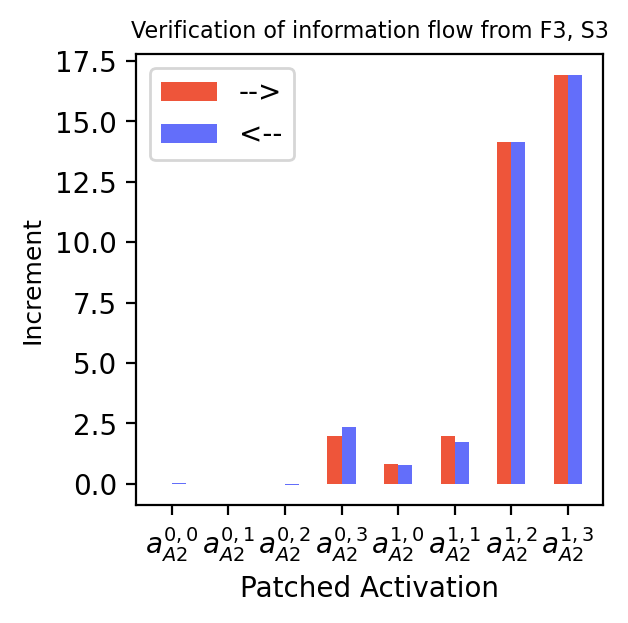

In [16]:
# with open("causal_exp.json") as f:
#     results = json.load(f)

fig, ax = plt.subplots(1, 1, figsize=(3,3), layout='constrained')
fig.set_dpi(200)
width = 0.25

results = {'forward': {'heads': [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3)], 'values': [-0.0014089303356215055, -0.0014276551341083632, -0.0017623198762386494, 1.9959713767070042, 2.81935232682679, 4.796778589975077, 18.953826072722723, 35.84909097591503]}, 'backward': {'heads': [(1, 3), (1, 2), (1, 1), (1, 0), (0, 3), (0, 2), (0, 1), (0, 0)], 'values': [16.919811888961377, 31.04188248127327, 32.77227775254849, 33.557656909367516, 35.92080271415482, 35.87522924996663, 35.8676086763583, 35.922029562409804]}}

heads = results["forward"]["heads"]

forward_values = results["forward"]["values"]
backward_values = results["backward"]["values"]
forward_values.insert(0, 0)
backward_values.insert(0, 0)
forward_values = np.array(forward_values)
forward_values = forward_values[1:] - forward_values[:-1]
backward_values = np.array(backward_values)
backward_values = backward_values[1:] - backward_values[:-1]
backward_values = np.flip(backward_values)


x = np.arange(len(heads))
rects = ax.bar(x-width/2, forward_values, width, label="-->", color="#EE553A")
rects = ax.bar(x+width/2, backward_values, width, label="<--", color="#636EFA")

ax.set_ylabel("Increment", fontsize=9)
ax.set_xlabel("Patched Activation")
ax.set_title("Verification of information flow from F3, S3", fontsize=8)

ax.legend(ncols=1) #loc="upper right", 
# ax.set_ylim(0, 15)

head_labels = ["$a^{%d,%d}_{A2}$"%(l, h) for l, h in heads]
ax.set_xticks(x, head_labels)



plt.show()